AxonaRecordingExtractor: 64 channels - 1 segments - 48.0kHz - 600.062s
  file_path: /home/isabella/Documents/isabella/jake/recording_data/r1398/2023-07-30/230730_r1398_raw_t-maze_1.set


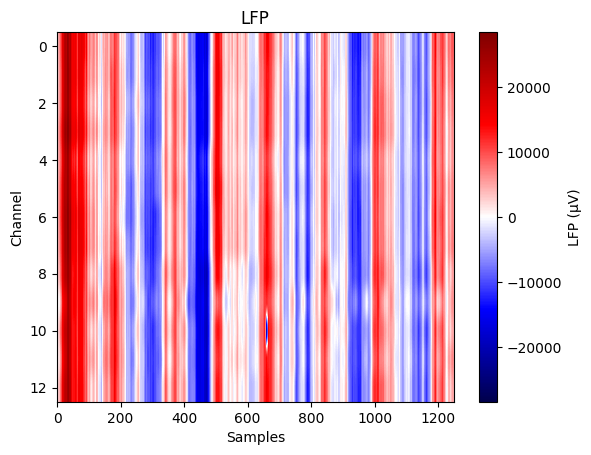

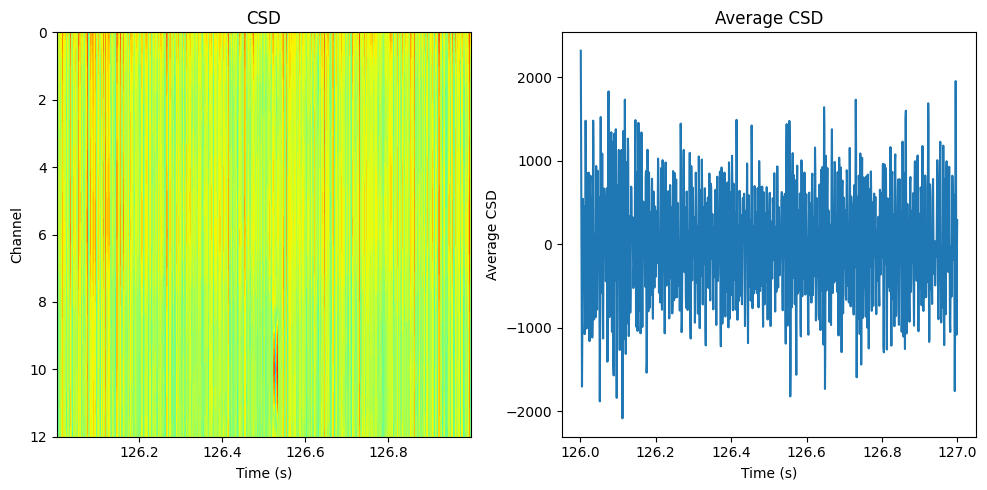

In [ ]:
import spikeinterface.extractors as se
import spikeinterface as si
import spikeinterface.preprocessing as spre
from bz_csd import *

filename = '/home/isabella/Documents/isabella/jake/recording_data/r1398/2023-07-30/230730_r1398_raw_t-maze_1.set'  # Replace with the path to your Axona raw file
recording = se.read_axona(filename)
print(recording)

sampling_rate = 1250
recording = spre.resample(recording, sampling_rate)

recording = spre.bandpass_filter(recording, freq_min = 1, freq_max = 300)

start_time = 126
end_time = 127
channels = range(24,37)
lfp_data = recording.get_traces(start_frame = start_time*sampling_rate, end_frame = end_time*sampling_rate)
lfp_timestamps = recording.get_times()[start_time*sampling_rate:end_time*sampling_rate]

lfp = {
    'data': lfp_data,
    'timestamps': lfp_timestamps,
    'samplingRate': sampling_rate
}

csd_result = bz_csd(lfp, spat_sm=5, temp_sm=7, plotLFP=True, plotCSD=True, channels = channels)


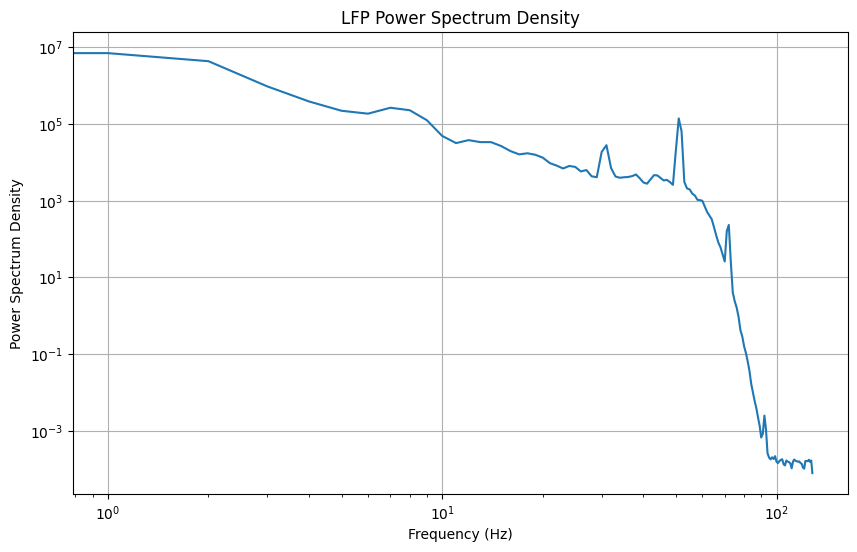

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

sampling_rate = 1250


# Compute the power spectrum density
frequencies, power_spectrum = signal.welch(lfp_data[:,30], fs=sampling_rate)

# Plot the power spectrum density
plt.figure(figsize=(10, 6))
plt.plot(power_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum Density')
plt.yscale('log')
plt.xscale('log')
# plt.xlim(0, 100)
plt.title('LFP Power Spectrum Density')
plt.grid(True)


# Find the frequency with the maximum power
# max_power_index = np.argmax(power_spectrum)
# max_power_frequency = frequencies[max_power_index]

# Annotate the frequency with the maximum power
# plt.annotate(f'Max Power Frequency: {max_power_frequency:2f} Hz',
#              xy=(max_power_frequency, power_spectrum[max_power_index]),
#              xytext=(max_power_frequency, power_spectrum[max_power_index] + 10))

plt.show()


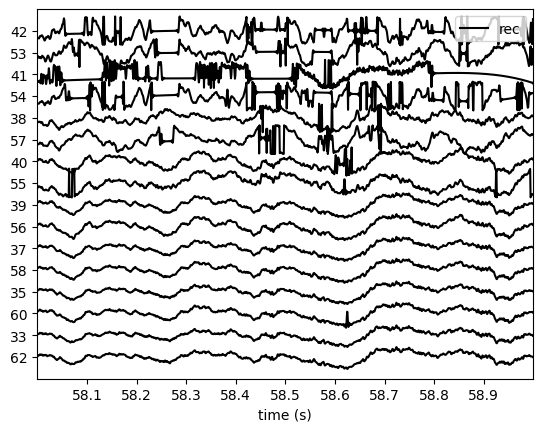

In [7]:
import matplotlib.pyplot as plt

import spikeinterface.extractors as se
import spikeinterface.widgets as sw
from probeinterface import read_prb
import probeinterface

probe = read_prb('/home/isabella/Documents/isabella/klusta_testdata/spikeinterface/probes/5x12-16_buz.prb')
singleProbe = probeinterface.Probe.from_dict(probe.to_dict()['probes'][0])
recording = recording.set_probe(singleProbe)

channels_str = []
for i in range(0, 63):
    channels_str.append(str(i))

w_ts = sw.plot_timeseries(recording, time_range = [58, 59], channel_ids = ['35', '58', '37', '56', '39', '55', '40', '57', '38', '54', '41', '53', '42', '60', '33', '62'], order_channel_by_depth = True, show_channel_ids = True)

In [24]:
import numpy as np
from scipy.signal import filtfilt, firwin, blackman

def lfpFilter(eeg, peakFreq, **kwargs):
    """Filter EEG within some frequency band and also extract phase.
    We'll try to remove dodgy bits from data by:
    a) Making sure that individual cycles have > threshold power
    b) Having lengths within limits of 'peakFreq+/-filtHalfBandWidth'.

    Usage:

        eegFilt, eegPhase, cycleN = lfpFilter(eeg, peakFreq)
        eegFilt, eegPhase, cycleN = lfpFilter(eeg, peakFreq, **optionalInputDict)
        eegFilt, eegPhase, cycleN = lfpFilter(eeg, peakFreq, inputName=inputVal, ... etc ...)

    Args:
        eeg (array): Array of single EEG trace.
        peakFreq (float): Peak frequency around which to filter EEG (in Hz).

    Keyword Args:
        Fs (float): Sample rate for EEG. Default is 250.
        filtHalfBandWidth (float): Filter around peakFreq +/- filtHalfBandWidth. Default is 3.
        powerThresh (float): Threshold (percentile) for min. power/cycle. Default is 5.

    Returns:
        eegFilt (array): Filtered EEG trace.
        eegPhase (array): Phase in radians of filtered EEG.
        cycleN (array): Numeric index for cycle number.
    """

    # Params
    prms = {
        'Fs': 1250,  # sample rate for eeg in Hz
        'filtHalfBandWidth': 3,  # filter around peakFreq +/- filtHalfBandWidth
        'powerThresh': 5,  # percentile
    }

    # Update params with provided keyword arguments
    for key, value in kwargs.items():
        prms[key] = value

    # Calculate passband frequency range
    passBand = np.array([-1, 1]) * prms['filtHalfBandWidth'] + peakFreq

    # Adjust numtaps to ensure odd number of coefficients
    numtaps = round(prms['Fs']) // 2 * 2 + 1

    # Convert cutoff to scalar values
    cutoff = (passBand / (prms['Fs'] / 2)).tolist()

    # Filter EEG
    window = blackman(numtaps + 1)
    window /= np.sum(window)  # Normalize the filter window
    taps = firwin(numtaps, cutoff, window=window)
    eegFilt = filtfilt(taps, 1, eeg)
    
    # Phase & Cycles
    if 'eegPhase' in kwargs:
        eegPhase = kwargs['eegPhase']
    else:
        eegPhase = np.angle(hilbert(eegFilt))  # hilbert transform
        eegPhase = np.mod(eegPhase, 2 * np.pi)  # Wrap into the range 0 - 2pi

    # Phase transitions, i.e. cycle boundaries
    phaseTrans = np.diff(eegPhase) < -np.pi
    phaseTrans = np.insert(phaseTrans, 0, True)
    phaseTrans = np.append(phaseTrans, True)
    # Remove phase slips
    phaseSlips = np.insert(np.diff(np.unwrap(eegPhase[1:] < 0)), 0, False)
    phaseSlips = np.append(phaseSlips, phaseSlips[-1])
    phaseTrans[phaseSlips] = False
    # Numeric cycle index
    cycleN = np.cumsum(phaseTrans)

    if 'powerPerCycle' in kwargs:
        powerPerCycle = kwargs['powerPerCycle']
    else:
        power = eegFilt ** 2
        powerPerCycle = np.bincount(cycleN[~phaseSlips], weights=power[~phaseSlips]) / np.bincount(cycleN[~phaseSlips])
    
    # Remove bad data
    thresh = np.percentile(powerPerCycle, prms['powerThresh'])
    badPowerCycle = np.where(powerPerCycle < thresh)[0]
    badPowerInd = np.isin(cycleN, badPowerCycle)
    cycleLength = np.bincount(cycleN)
    cycleLengthLim = np.ceil(1 / passBand * prms['Fs'])
    badLengthCycle = np.where((cycleLength < cycleLengthLim[1]) | (cycleLength > cycleLengthLim[0]))[0]
    badLengthInd = np.isin(cycleN, badLengthCycle)
    
    cycleN[badLengthInd | badPowerInd] = np.nan
    eegPhase[badLengthInd | badPowerInd] = np.nan

    return eegFilt, eegPhase, cycleN

lfpFilter(traces, peakFreq = 7)

ValueError: <class 'numpy.ndarray'> as window type is not supported.